In [1]:
# for operating system 
import os

# for data manipulation
import pandas as pd
import numpy as np

# for data viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')


# for a cleaner kennel 
import warnings
warnings.filterwarnings('ignore')
cwd = os.getcwd()
display(cwd)

'/Users/fni/Desktop/Python/Lenus_case'

In [2]:
#Change formatting for standard Pandas

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = "{:.2f}".format

#Reset all formating
#pd.reset_option("^display")

In [3]:
#importing data
file='customer_data_sample.csv'
df = pd.read_csv(file)

print('This dataset have {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

df.head(5)

This dataset have 891 rows and 10 columns.


,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,0,13,male,22.00,1,0,14.50,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
1,15002,1,11,female,38.00,1,0,142.57,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
2,15003,1,13,female,26.00,0,0,15.85,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
3,15004,1,11,female,35.00,1,0,106.20,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki
4,15005,0,13,male,35.00,0,0,16.10,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki


In [4]:
df.info() # lets dive deeper into the the data and look at the dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        891 non-null    int64  
 1   converted          891 non-null    int64  
 2   customer_segment   891 non-null    int64  
 3   gender             891 non-null    object 
 4   age                714 non-null    float64
 5   related_customers  891 non-null    int64  
 6   family_size        891 non-null    int64  
 7   initial_fee_level  891 non-null    float64
 8   credit_account_id  891 non-null    object 
 9   branch             889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


Now we have some data preprocessing issues we need to deal with:

1) customer_id are all unique or do we have duplicates - if no duplicates then we can simply get rid of it

2) gender is object and we want it to be normeric

3) credit_account_id here is the same issue as with gender

4) branch have 2 nan's and it is non-nomeric

5) age we have 177 nan's and we need to deal with it

6) last we might have to deal with some feature engineering for customer_segment and branch as they are catagorical

In [5]:
#1)
print(df.customer_id.nunique()) #checking for duplicates in customer id
df.drop('customer_id', axis=1, inplace=True) #because all are unique we will remove them

891


In [6]:
#2) & 3)
df['gender']=df['gender'].apply(lambda val:  1 if val == 'male' else 0) # 1 if male 0 if female
df['credit_account_id']=df['credit_account_id']\
.apply(lambda val:  0 if val == "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0" else 1)
# 1 if account is connected 0 otherwise
# Lets rename the column for giving us a better understanding of what the column contains
df.rename(columns = {'credit_account_id': 'credit_account_connected'}, inplace = True)
print('This dataset have now new columns with the naming:\n {}.'.format(list(df.columns)))

This dataset have now new columns with the naming:
 ['converted', 'customer_segment', 'gender', 'age', 'related_customers', 'family_size', 'initial_fee_level', 'credit_account_connected', 'branch'].


In [7]:
#4) 
branch_=dict(zip(list(df.branch),[list(df.branch).count(i) for i in list(df.branch)]))
print('Before: {}'.format(branch_))

# Get first value from dictionary
Helsinki = list(branch_.values())[0]
all_branches=sum(branch_.values())
print('Helsinki accounts for: {:.2f}% of all branches'.format(Helsinki/all_branches*100))

# Because Helsinki accounts for a majority of all branches, lets just replace the nan's to Helsinki
df.branch.fillna('Helsinki',inplace=True)
print('After:{}'.format(dict(zip(list(df.branch),[list(df.branch).count(i) for i in list(df.branch)]))))

Before: {'Helsinki': 644, 'Tampere': 168, 'Turku': 77, nan: 2}
Helsinki accounts for: 72.28% of all branches
After:{'Helsinki': 646, 'Tampere': 168, 'Turku': 77}


it look like the missing data is missing compltely at random


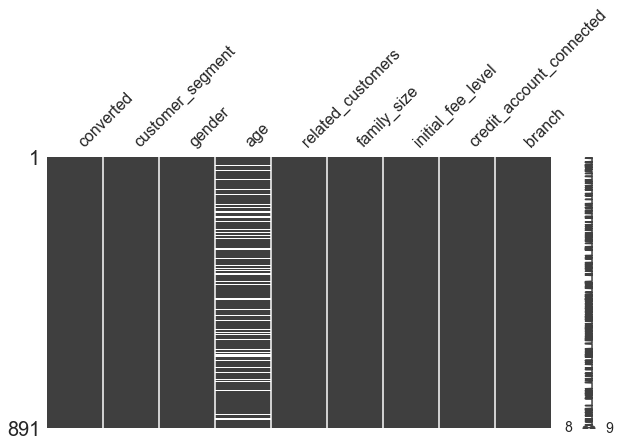

In [8]:
#5 
#Lest first explore if the missing data from the age column looks systematically or random
# for nan's
import missingno as msno # missingno can get corruptet use -> pip install --force-reinstall --no-cache-dir missingno
msno.matrix(df,figsize=(10,5)) # using the library missingno for analysing missing values 
print('it look like the missing data is missing compltely at random')

Missingness of age for segments: customer_segment
11   0.14
12   0.06
13   0.28
dtype: float64


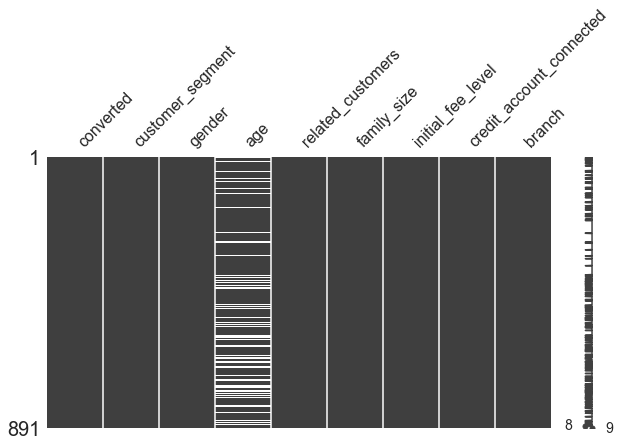

In [9]:
sorted_=df.sort_values('customer_segment') #Lets try and sort the values for customer_segment
msno.matrix(sorted_,figsize=(10,5))
df2=df.copy()
df2['age_nan']=df2.age.isna()
print('Missingness of age for segments: {}'.format(df2.groupby('customer_segment')\
                                                   ['age_nan'].sum()/df2.groupby('customer_segment').size()))

When sorting the values for customer_segment it seem like there are some sortof correlation between segments and missing age (a somewhat similar pattern apear with age and initial_fee_level). 

There could be numerous reasons for this however my hunch tell that there is something endogeouns happening here. 

customer_segment is probaly a product of other variable such as perhaps 'initial_fee_level', 'credit_account_connected', 'branch' and 'age' which could explain why the missing values are somewhat clustered together. Thus people of these characteristica dont like to report there age.  

another reason could perhaps be that a customer is assigned a segment based on there source of entry and one of those sources could have an unreliable connection for carrying over datapoints on age.

However our next challenge lies in finding a way to impute the nan's in the age column intelligently. 


In [10]:
# both 'branch','customer_segment' are ordinal values, lets one-hot encode them for being able to work with them
import category_encoders as ce
from sklearn import preprocessing
#Create object for one-hot encoding
encoder=ce.OneHotEncoder(cols=['branch','customer_segment'],\
                         handle_unknown='return_nan',return_df=True,use_cat_names=True)
#Fit and transform Data
data_encoded = encoder.fit_transform(df)

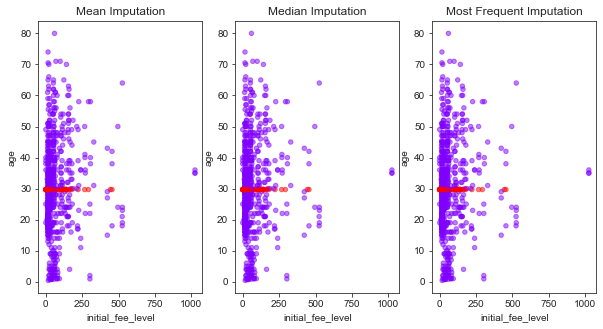

In [11]:
from sklearn.impute import SimpleImputer

age_mean = data_encoded.copy(deep=True)
mean_imputer = SimpleImputer(strategy='mean')
age_mean.iloc[:, :] = mean_imputer.fit_transform(age_mean)

age_medean = data_encoded.copy(deep=True)
medean_imputer = SimpleImputer(strategy='median')
age_medean.iloc[:, :] = mean_imputer.fit_transform(age_medean)

age_mode = data_encoded.copy(deep=True)
mode_imputer = SimpleImputer(strategy='most_frequent')
age_mode.iloc[:, :] = mean_imputer.fit_transform(age_mode)


nullity = data_encoded.age.isnull()+data_encoded.initial_fee_level.isnull()

imputations = {'Mean Imputation': age_mean, 'Median Imputation': age_medean, 
               'Most Frequent Imputation': age_mode}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

# Loop over flattened axes and imputations
for ax, df_key in zip(axes.flatten(), imputations):
    # Select and also set the title for a DataFrame
    imputations[df_key].plot(x='initial_fee_level', y='age', kind='scatter', 
                          alpha=0.5, c=nullity, cmap='rainbow', ax=ax, 
                          colorbar=False, title=df_key)
plt.show()

Observing the graph, there are no correlation between e.g. 'initial_fee_level' and 'age'. The imputed values which are red just lie in a straight line as the imputed values do not vary against the other variable. Therefore, we can conclude that mean, median and mode imputations preserve these basic statistical features of the dataset and will not bias the dataset. However, there might be more robust way of inputing this.

In [12]:
from fancyimpute import KNN

knn_impute = KNN()

df_knn = data_encoded.copy()

df_knn.iloc[:,:] = knn_impute.fit_transform(df_knn) 

Imputing row 1/891 with 0 missing, elapsed time: 0.144
Imputing row 101/891 with 0 missing, elapsed time: 0.146
Imputing row 201/891 with 0 missing, elapsed time: 0.147
Imputing row 301/891 with 1 missing, elapsed time: 0.148
Imputing row 401/891 with 0 missing, elapsed time: 0.149
Imputing row 501/891 with 0 missing, elapsed time: 0.150
Imputing row 601/891 with 0 missing, elapsed time: 0.151
Imputing row 701/891 with 0 missing, elapsed time: 0.152
Imputing row 801/891 with 0 missing, elapsed time: 0.153


In [13]:
from fancyimpute import IterativeImputer

mice_impute = IterativeImputer()

df_mice = data_encoded.copy()

df_mice.iloc[:,:] = mice_impute.fit_transform(df_mice) 

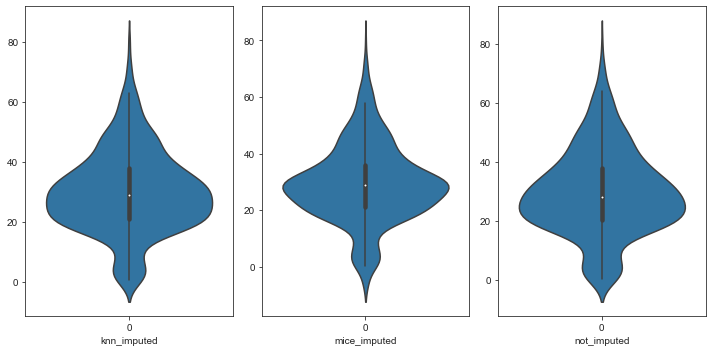

In [14]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 3)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(data=df_knn.age)
ax.set_xlabel("knn_imputed")

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(data=df_mice.age)
ax.set_xlabel("mice_imputed")

ax = fig.add_subplot(gs[0, 2])
sns.violinplot(data=df.age)
ax.set_xlabel("not_imputed")

fig.tight_layout()
plt.show()

Looking at the plots the knn imputed data looks most similar to the original data. However, examine the mean we see that the mice imputed data is closer to that of the original data. BUT the mice algoritme is a heavyli statically based model which is allso why the distribution now assumes a more normal looking distribution and sets some ages below zero which we know is not possible. Moreover, we should probaly not expect the data to be nomally distributed as this "product" seems seems to be mostly for people between 20 to 40 years of age or some who have been part of the data based for years long.It definitely do not make sense to have a negative age. Thus we will move forward the knn imputed data.

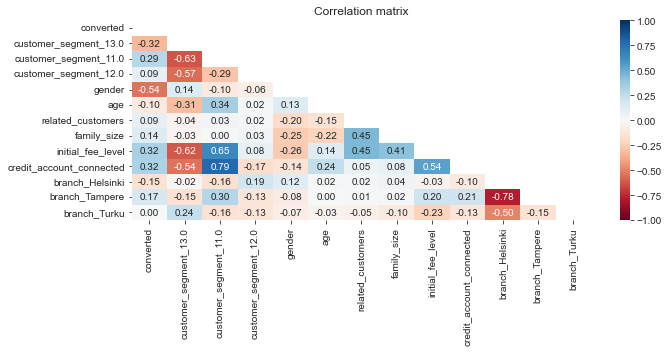

In [15]:
#only for Corr matrix
# Use Spearman instead of default Pearson, since we have are ordinal variables!
corr_matrix = df_knn.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Setup
fig, ax = plt.subplots(figsize=(10, 5))

# vmin and vmax control the range of the colormap
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
           vmin=-1, vmax=1,mask=mask)

plt.title("Correlation matrix")

# Add tight_layout to ensure the labels don't get cut off
plt.tight_layout()
plt.show()

First it seem like there is a connection between 'initial_fee_level' and 'credit_account_connected' for being i segment 11.0 while there is a negative realationship whith segment 13.0. What more is interesting is that there is a somewhat positive correlation between 'related_customers' and 'family_size' and 'initial_fee_level'. Lastly we see a negative realationship between being male and have 'converted'

### Now lets dive deeper into the data and understanding through the use of ML models. 

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
# explicitly require this experimental feature

class Simple_autoML_BinaryClass:
    def __init__(self, data_path, target_column, model_type):
        """Sample AutoML API that deals with binary classification problems.
        Args:
            data_path (str): Location of your sample dataset - place it in the same location as the code.
            target_column (str): Column you are trying to predict.
            model_type (str): Options are linear_regression and random_forest. #Change
            
        """
        self.data_path = data_path
        self.target_column = target_column
        self.model_type = model_type
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.train_ = None
        self.test_ = None 
        self.my_model = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.best_score = None
        self.accuracy = None
        self.confusion = None
        self.best_params = None


    def preprocess(self):
        df = self.data_path
        columns = df.columns
        if self.target_column not in columns:
            raise ValueError("Target column not present in dataset")
        X = df.drop([self.target_column], axis = 1) 
        y = df[self.target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify=y,\
                                                            random_state = 42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_train_scaled = StandardScaler().fit_transform(X_train)
        self.X_test_scaled = StandardScaler().fit_transform(X_test)
        
    def train(self):
        model_types = ['LogisticRegression', 'DecisionTreeClassifier','RandomForestClassifier'] #Change
        if self.model_type not in model_types:
            raise ValueError(f"Enter a model type that is supported from the following list: {model_types}")

        if self.model_type == "LogisticRegression": 
            #Params for LogisticRegression
            solvers = ['newton-cg', 'lbfgs', 'liblinear']
            penalty = ['l1', 'l2', 'elasticnet', 'none']
            c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]
            max_iter_values= np.arange(100, 2000, step=50)
            # define grid search
            dict_ = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=max_iter_values)
            #Model Creation for DecisionTreeClassifier
            model_=RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=dict_, n_jobs=-1,\
                                      cv=3, n_iter=100,\
                        random_state=1111, refit=True, scoring='accuracy',error_score=0)
            model_.fit(self.X_train_scaled,self.y_train)
            best_pred_y = model_.predict(self.X_test_scaled)
            #Model prediction
            best_score=(model_.best_score_)*100
            accuracy=accuracy_score(self.y_test, best_pred_y)*100
            confusion_m=confusion_matrix(self.y_test, best_pred_y)
            best_params=model_.best_params_
            #Model for explaining
            model_=LogisticRegression(solver=model_.best_params_.get('solver'),\
                                          penalty=model_.best_params_.get('penalty'),\
                                          C=model_.best_params_.get('C'),\
                                          max_iter=model_.best_params_.get('max_iter'))
            model_.fit(self.X_train,self.y_train)            
                      
        elif self.model_type == "DecisionTreeClassifier": 
            #Params for DecisionTreeClassifier
            param_dist = {"max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,None],
                          "max_features": [1,2,3,4,5,6,7,8,9],
                          "min_samples_leaf": [1,2,3,4,5,6,7,8,9],
                          "criterion": ["gini", "entropy"],
                          'ccp_alpha':[100, 10, 1.0, 0.1, 0.01, 0.001]}
            #Model Creation for RandomForestClassifier
            model_=RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=param_dist,\
                                    cv=3, n_iter=200, random_state=1111, refit=True)
            model_.fit(self.X_train,self.y_train)
            best_pred_y = model_.predict(self.X_test)
            #Model prediction
            best_score=(model_.best_score_)*100
            accuracy=accuracy_score(self.y_test, best_pred_y)*100
            confusion_m=confusion_matrix(self.y_test, best_pred_y)
            best_params=model_.best_params_
            #Model for explaining
            model_=DecisionTreeClassifier(max_depth=model_.best_params_.get('max_depth'),\
                                          max_features=model_.best_params_.get('max_features'),\
                                          min_samples_leaf=model_.best_params_.get('min_samples_leaf'),\
                                          criterion=model_.best_params_.get('criterion'),\
                                          ccp_alpha=model_.best_params_.get('ccp_alpha'))
            model_.fit(self.X_train,self.y_train)            
            
        elif self.model_type == "RandomForestClassifier": 
            #Params for RandomForestClassifier
            n_estimators = np.arange(100, 1000, step=100)
            max_features = ["auto", "sqrt", "log2"]
            max_depth = list(np.arange(10, 100, step=10)) + [None]
            min_samples_split = np.arange(2, 10, step=2)
            min_samples_leaf = [1, 2, 4]
            bootstrap = [True, False]
            param_grid = {
                "n_estimators": n_estimators,
                "max_features": max_features,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
                "min_samples_leaf": min_samples_leaf,
                "bootstrap": bootstrap}
            #Model Creation for RandomForestClassifier
            model_=RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid,\
                                      cv=3, n_iter=2, random_state=1111, refit=True)
            model_.fit(self.X_train,self.y_train)
            best_pred_y = model_.predict(self.X_test)
            #Model prediction
            best_score=(model_.best_score_)*100
            accuracy=accuracy_score(self.y_test, best_pred_y)*100
            confusion_m=confusion_matrix(self.y_test, best_pred_y)
            best_params=model_.best_params_
            #Model for explaining
            model_=RandomForestClassifier(n_estimators=model_.best_params_.get('n_estimators'),\
                                          max_features=model_.best_params_.get('max_features'),\
                                          max_depth=model_.best_params_.get('max_depth'),\
                                          min_samples_split=model_.best_params_.get('min_samples_split'),\
                                          min_samples_leaf=model_.best_params_.get('min_samples_leaf'),\
                                          bootstrap=model_.best_params_.get('bootstrap'))
            model_.fit(self.X_train,self.y_train)
            
        self.my_model = model_
        self.best_score = best_score
        self.accuracy = accuracy
        self.confusion = confusion_m
        self.best_params = best_params

    def explain(self):
        if self.model_type == "LogisticRegression" : #Change
            return f"{pd.DataFrame(zip(self.X_train.columns, np.transpose(self.my_model.coef_)),columns=['features', 'coef'])}, intercept: {self.my_model.intercept_}"
        
        elif self.model_type == "DecisionTreeClassifier" :
            sorted_feature_weight_idxes = np.argsort(self.my_model.feature_importances_)[::-1]
            most_important_features = np.take_along_axis(np.array(self.X_train.columns.tolist()),sorted_feature_weight_idxes, axis=0)
            most_important_weights = np.take_along_axis(np.array(self.my_model.feature_importances_), sorted_feature_weight_idxes, axis=0)
            return plt.barh(most_important_features[::-1], most_important_weights[::-1])        
        
        elif self.model_type == "RandomForestClassifier" :
            sorted_feature_weight_idxes = np.argsort(self.my_model.feature_importances_)[::-1]
            most_important_features = np.take_along_axis(np.array(self.X_train.columns.tolist()),sorted_feature_weight_idxes, axis=0)
            most_important_weights = np.take_along_axis(np.array(self.my_model.feature_importances_), sorted_feature_weight_idxes, axis=0)
            return plt.barh(most_important_features[::-1], most_important_weights[::-1])      
            
        else:
            return f" This model can not be explained: {self.model_type}" #Change
    
    
    def logModelInfo(self):
            modelDetails = {
                "ModelType": self.model_type,
                "Best train score": "{:.2f}%".format(self.best_score),
                "Accuracy":"{:.2f}%".format(self.accuracy),
                "Confusion Matrix:": "{}".format(self.confusion),
                "Best params for random search:": self.best_params
            }
            return modelDetails

In [17]:
#First lets explore LogisticRegression
if __name__ == '__main__':
    auto_model = Simple_autoML_BinaryClass(df_knn, "converted", "LogisticRegression")
    auto_model.preprocess()
    auto_model.train()
    print(auto_model.logModelInfo())
    print(auto_model.explain())
    odds_ration=auto_model.explain()
#We see that the model has sligtly overfitted

{'ModelType': 'LogisticRegression', 'Best train score': '82.02%', 'Accuracy': '78.77%', 'Confusion Matrix:': '[[99 11]\n [27 42]]', 'Best params for random search:': {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1800, 'C': 0.01}}
                    features                     coef
0      customer_segment_13.0   [-0.23513019522031886]
1      customer_segment_11.0    [0.14207380326030453]
2      customer_segment_12.0    [0.09305641274518113]
3                     gender    [-0.5561495982169026]
4                        age  [-0.028254233182341208]
5          related_customers   [-0.13424488866643006]
6                family_size   [0.004501898187685865]
7          initial_fee_level   [0.006914025261823524]
8   credit_account_connected     [0.2147370273604153]
9            branch_Helsinki    [-0.1096880837171365]
10            branch_Tampere    [0.06137231704382044]
11              branch_Turku    [0.04831578745848297], intercept: [0.44102067]


In [18]:
#Lets interpret some of the coefficient: 

print("Males has {:.2f}% less odds of not having converted compared to females when all else is equal."\
      .format((np.exp(-0.5561495982169026)-1)*100))
print("\n")
print("Having credit_account_connected increases the odds by {:.2f}% of having converted compared to not\
credit_account_connected when all else is equal."\
      .format((np.exp(0.2147370273604153)-1)*100))
print("\n")
print("people knowing one unit more related_customers has {:.2f}% less odds of having converted\
then people who do not when all else is equal.".format((np.exp(-0.13424488866643006)-1)*100))


Males has -42.66% less odds of not having converted compared to females when all else is equal.


Having credit_account_connected increases the odds by 23.95% of having converted compared to notcredit_account_connected when all else is equal.


people knowing one unit more related_customers has -12.56% less odds of having convertedthen people who do not when all else is equal.


{'ModelType': 'DecisionTreeClassifier', 'Best train score': '82.72%', 'Accuracy': '78.77%', 'Confusion Matrix:': '[[101   9]\n [ 29  40]]', 'Best params for random search:': {'min_samples_leaf': 4, 'max_features': 6, 'max_depth': 4, 'criterion': 'gini', 'ccp_alpha': 0.001}}
<BarContainer object of 12 artists>


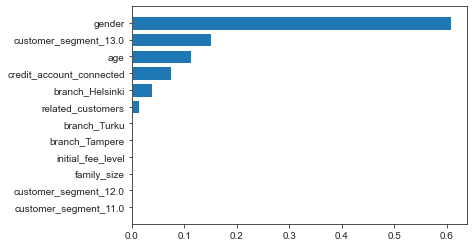

In [19]:
#Secound lets explore DecisionTreeClassifier
if __name__ == '__main__':
    auto_model = Simple_autoML_BinaryClass(df_knn, "converted", "DecisionTreeClassifier")
    auto_model.preprocess()
    auto_model.train()
    print(auto_model.logModelInfo())
    print(auto_model.explain())
#We see that the model has sligtly overfitted

The DecisionTreeClassifier deems: 'gender', 'age', 'credit_account_connected', 'Customer_Segment_13.0 for being the most importent variables for explain either having converted or not having converted

{'ModelType': 'RandomForestClassifier', 'Best train score': '82.59%', 'Accuracy': '78.77%', 'Confusion Matrix:': '[[97 13]\n [25 44]]', 'Best params for random search:': {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}}
<BarContainer object of 12 artists>


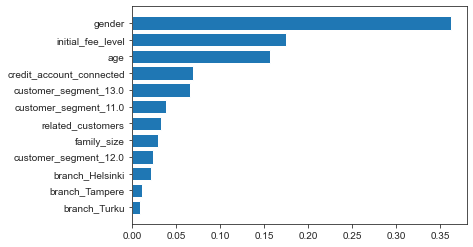

In [20]:
#Lastly lets explore LogisticRegression
if __name__ == '__main__':
    auto_model = Simple_autoML_BinaryClass(df_knn, "converted", "RandomForestClassifier")
    auto_model.preprocess()
    auto_model.train()
    print(auto_model.logModelInfo())
    print(auto_model.explain())
#We see that the model has sligtly overfitted

The RandomForestClassifier do somewhat agree with DecisionTreeClassifier and deems: 'gender', 'age', 'credit_account_connected', 'Customer_Segment_13.0, but also initial_fee_level for being the most importent variables for explain either having converted or not having converted. Moreover, it finds some information in all some the variable while the DecisionTreeClassifier only finds information in 6 variables.

### Conclussion:

### is that Gender the most explained variable for having converted. Addionally, credit_account_connected and initial_fee_level are explainers for having converted

### We have some data issues with with observation possible being dependend of each other and introduces multicollinearity. Thus, some domain expertise would have been much appreciated. Moreover the data sample is quite small. I would be careful to conclude to much on this without knowing the whole story of how data is related

### An alternative option could be to account for outlier or balance the dataset 50/50. 
#locating outlier from initial_fee_level group
from numpy import mean
from numpy import std
#calculate summary statistics
data_mean, data_std = mean(df_knn['initial_fee_level']), std(df_knn['initial_fee_level'])
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
...
#identify outliers
outliers_ = [x for x in df_knn['initial_fee_level'] if x < lower or x > upper]

df_knn.drop(df_knn[df_knn.initial_fee_level >= min(outliers_)].index, inplace=True)